In [107]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense
from keras.initializers import RandomNormal

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from Brownian_Sim_Wrappers import *

In [108]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 3070


In [109]:
# Define simulator models

myGVolWrap = GBMVolWrapper()
myGCorrWrap = GBMCorrWrapper()
myGCovWrap = GBMCovWrapper()
myAVolWrap = ABMVolWrapper()
myACorrWrap = ABMCorrWrapper()
myACovWrap = ABMCovWrapper()

def norm_wrapper(sim):
    data = sim(x0=[random.randint(50, 100) for _ in range(3)])['motion'][:, 0]
    data = np.clip(data, a_min=1e-8, a_max=None)
    log_ret = np.log(data[1:] / data[:-1])
    return log_ret

def x0(): 
    return 

brownian_models = [
    lambda s : [norm_wrapper(myGVolWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myGCorrWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myGCovWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myAVolWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myACorrWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myACovWrap) for _ in range(s)]
]


In [110]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = bf.networks.DeepSet(summary_dim=16, dropout=0.1)
        self.classification_network = bf.networks.MLP(
            widths=[32] * 4, activation="silu", dropout=None)

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [114]:
# Data Preparation

BATCH_SIZE = 128
TRAIN_BATCHES = 128
VAL_BATCHES = 8
EPOCHS = 20

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

In [115]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(brownian_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [116]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - loss: 3.9079 - multimodel_accuracy: 0.3732 - val_loss: 2.6172 - val_multimodel_accuracy: 0.5732
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - loss: 2.7002 - multimodel_accuracy: 0.5438 - val_loss: 2.5519 - val_multimodel_accuracy: 0.5586
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - loss: 2.4202 - multimodel_accuracy: 0.5995 - val_loss: 2.3108 - val_multimodel_accuracy: 0.6328
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - loss: 2.5387 - multimodel_accuracy: 0.5900 - val_loss: 2.4120 - val_multimodel_accuracy: 0.5928
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - loss: 2.3021 - multimodel_accuracy: 0.6417 - val_loss: 2.1692 - val_multimodel_accuracy: 0.6885
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - loss: 2.3832 - multimodel_accuracy: 0.6310 - val_loss: 2.3537 - val_multimodel_accuracy: 0.6455
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 2.2210 - multimodel

In [117]:
# Accuracy

for idx, func in enumerate(brownian_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    # Predict
    f_x = model.predict(X_test[:, :, None], verbose=0)

    acc = multimodel_accuracy(y_test, f_x)
    print(f" Model {idx} accuracy: {acc*100:.2f}%")

 Model 0 accuracy: 87.00%
 Model 1 accuracy: 93.00%
 Model 2 accuracy: 39.00%
 Model 3 accuracy: 6.00%
 Model 4 accuracy: 100.00%
 Model 5 accuracy: 15.00%



Loss History


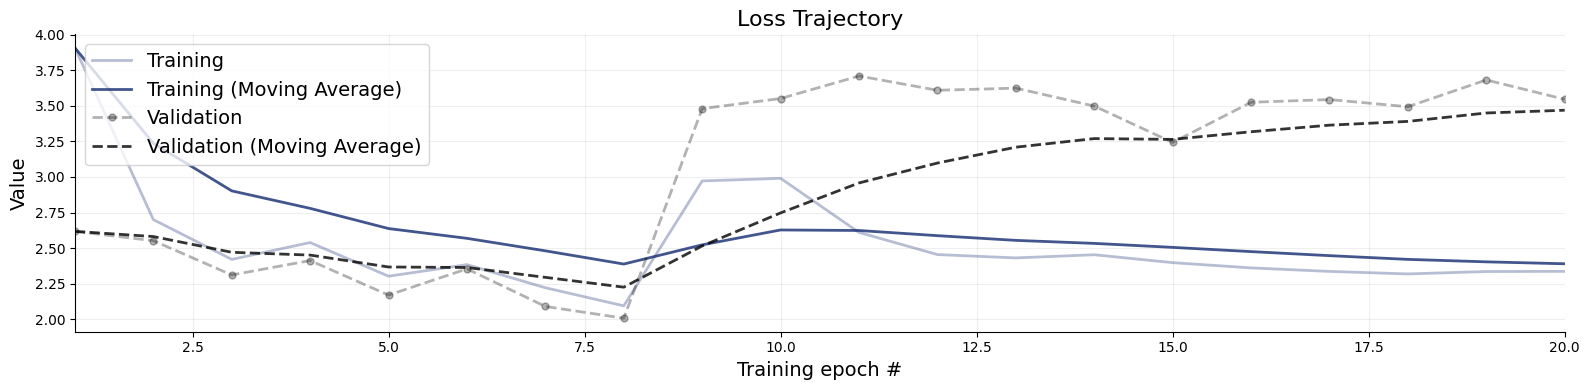

In [121]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()